In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import re

from sklearn.metrics import precision_recall_curve, mutual_info_score, normalized_mutual_info_score

from pyspark.ml.feature import HashingTF, Tokenizer, IDF, StopWordsRemover, CountVectorizer, VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.functions import explode, lit, col, when

import matplotlib.pyplot as plt

from hashtag_dict import topic_dict

from Evaluation import *
from FeatureExtraction import *
from Filter import *
from TestFramework import *
from LPFormulations import *
from CoverageCalculator import *

# Review Previous Work

In [2]:
class API:
    def __init__(self, directory, frac=1, seed=123):
        if frac < 1:
            self.data = spark.read.parquet(directory).sample(False, frac, seed)
        else:
            self.data = spark.read.parquet(directory)
          
    def get_raw_data(self):
         return self.data

    def get_filtered_data(self, terms=[], hashtags=None, users=None, locs=None, mentions=None):   
        return filter_data(self.data, terms, hashtags, users, locs, mentions)
    
    
class DataPreprocessor():
    def __init__(self, data, topic, load_labled=False, filter_empty_hashtags=False):
        if filter_empty_hashtags == True:
            self.data = data.filter(col("hashtag") != "empty_hashtag")
        else:
            self.data = data

        if load_labled == True:
            labled_dir = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/" + topic
            pos_dir = labled_dir + "/pos"
            topical_tweet_ids = spark.read.parquet(pos_dir)
            topical_tweets = topical_tweet_ids.join(self.data, "tweet_id").withColumn("label", lit(1))
            
            neg_dir = labled_dir + "/neg"
            non_topical_tweet_ids = spark.read.parquet(neg_dir).sample(False, 0.1, 123)
            non_topical_tweets = non_topical_tweet_ids.join(self.data, "tweet_id").withColumn("label", lit(0))

            self.labled_data = topical_tweets.union(non_topical_tweets)
        else:
            self.labled_data = None

        tokenizer = Tokenizer(inputCol="hashtag", outputCol="each_hashtag")
        hashtags_df = tokenizer.transform(self.data)

        hashtag = hashtags_df.select("tweet_id","create_time","each_hashtag")
        self.hash_exploded = hashtag.withColumn('each_hashtag', explode('each_hashtag'))
    
    def get_labled_data(self, topic):
        if self.labled_data == None:
            topic_lables = topic_dict[topic]

            topical_ids = self.hash_exploded.select(self.hash_exploded.tweet_id)\
                                                    .where(self.hash_exploded.each_hashtag\
                                                            .isin(topic_lables))\
                                                    .distinct().cache()

            labled_topical = topical_ids.withColumn("topical", lit(1))
            self.labled_data = self.data.join(labled_topical, self.data.tweet_id == labled_topical.tweet_id, "left")\
                                                      .select(self.data.create_time,\
                                                             self.data.from_id,\
                                                             self.data.from_user,\
                                                             self.data.hashtag,\
                                                             self.data.location,\
                                                             self.data.mention,\
                                                             self.data.tweet_id,\
                                                             self.data.term,\
                                                              F.when(labled_topical.topical == 1, 1.0)\
                                                                .otherwise(0.0).alias("label"))
        return self.labled_data
    
    def get_num_of_positvies(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.where(col("label") == 1.0).count()
    
    def get_data_size(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.count()
        
    def temporal_split(self, topic, balance_data=True, seed=0, remove_topic_hashtags=False):
        topic_lables = topic_dict[topic]
        labled_data = self.get_labled_data(topic)
        tweet_labels = labled_data.select("tweet_id", "label")
        
        df_birthday = self.hash_exploded.join(tweet_labels,\
                                 self.hash_exploded.tweet_id == tweet_labels.tweet_id,\
                                 "inner").select(self.hash_exploded.create_time,\
                                                 self.hash_exploded.each_hashtag,\
                                                 self.hash_exploded.tweet_id)
        
        ## Find out the "birthday", or the earliest appearing time of each hashtag. 
        ## (add an extra column of 1 to mark as topical, will be used in a join later)
        ordered_hashtag_set = df_birthday.\
                              groupby("each_hashtag").\
                              agg({"create_time": "min"}).\
                              orderBy('min(create_time)', ascending=True).\
                              withColumnRenamed("min(create_time)", "birthday").\
                              where(df_birthday.each_hashtag.isin(topic_lables)).cache()
                            
        time_span = ordered_hashtag_set.count()

        train_valid_split_time = np.floor(np.multiply(time_span, 0.75)).astype(int)
        valid_test_split_time = np.floor(np.multiply(time_span, 0.85)).astype(int)

        # Converting to Pandas for random row access.
        pd_ordered_hashtag_set = ordered_hashtag_set.toPandas()
        
        # locate the timestamp of the cutoff point. Will be used later to split Dataframe.
        train_valid_time = pd_ordered_hashtag_set.iloc[train_valid_split_time]['birthday']
        valid_test_time = pd_ordered_hashtag_set.iloc[valid_test_split_time]['birthday']
    
        training_set = labled_data.where(col("create_time") <= train_valid_time)
        validation_set = labled_data.where((col("create_time") > train_valid_time) \
                                           & (col("create_time") <= valid_test_time))
        test_set = labled_data.where(col("create_time") > valid_test_time)
        
        if remove_topic_hashtags == True:
            train_hashtags = pd_ordered_hashtag_set[:train_valid_split_time]['each_hashtag'].tolist()
            train_valid_hashtags = pd_ordered_hashtag_set[:valid_test_split_time]['each_hashtag'].tolist()
            
            train_hashtags_filter = [re.sub(r'(.*)', r'\\b\1\\b', hashtag) for hashtag in train_hashtags]
            train_hashtags_regex = '|'.join(train_hashtags_filter)
            invalid_validation_ids = (validation_set.filter(validation_set['hashtag'].rlike(train_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()
            validation_set = validation_set.where(~col("tweet_id").isin(invalid_validation_ids))
            
            train_valid_hashtags_filter = [re.sub(r'(.*)', r'\\b\1\\b', hashtag) for hashtag in train_valid_hashtags]
            train_valid_hashtags_regex = '|'.join(train_valid_hashtags_filter)
            invalid_test_ids = (test_set.filter(test_set['hashtag'].rlike(train_valid_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()
                
            test_set = test_set.where(~col("tweet_id").isin(invalid_test_ids))
        
        if balance_data == True:
            train_pos_count = training_set.where(col("label") == 1).count()
            train_neg_count = training_set.count() - train_pos_count
            train_pos_neg_ratio = float(train_pos_count) / train_neg_count
            
            training_set = training_set.sampleBy("label", fractions={0.0: train_pos_neg_ratio, 1.0: 1}, seed=seed)
            
            valid_pos_count = validation_set.where(col("label") == 1).count()
            valid_neg_count = validation_set.count() - valid_pos_count
            valid_pos_neg_ratio = float(valid_pos_count) / valid_neg_count
            
            validation_set = validation_set.sampleBy("label", fractions={0.0: valid_pos_neg_ratio, 1.0: 1}, seed=seed)
            
        return training_set, validation_set, test_set

In [3]:
directory = "/mnt/66e695cd-1a0c-4e3b-9a50-55e01b788529/Training_data/Staging_final/"
api = API(directory)
raw_data = api.get_raw_data()

# 1) Space

First, process and save data:

In [47]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Space"

train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna()

In [49]:
test = test_pd.drop_duplicates(subset='term').reset_index()
valid = validation_pd.drop_duplicates(subset='term').reset_index()
train = train_pd.drop_duplicates(subset='term').reset_index()

tf = TestFramework(train, valid, test)

domain_stopwords = ['rt', 'amp', 'empty_location', 'empty_mention']
positive_set, negative_set = get_transformed_data(test, tf.get_pipeline(),\
                                                  stopwords=domain_stopwords)

num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
    get_coverage(tf.get_pipeline(), positive_set, negative_set)

Initializing Classifier....
Complete!
#pos/#neg = 0.0169957516925


In [76]:
greedy_selected_features = greedy_max_cover(positive_set, negative_set, tf.get_pipeline(), k=50, print_solve_time=True)

Running Time: 35.1379630566 Seconds


In [77]:
get_feature_by_index(tf.get_pipeline(), greedy_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,houston,Hashtag,5260,0
1,starwars,Hashtag,3642,0
2,science,Hashtag,2945,0
3,sxsw,Hashtag,2898,0
4,iss,Hashtag,2445,0
5,stem,Hashtag,2301,0
6,scifi,Hashtag,1786,0
7,nasa,Mention,1783,8
8,rockets,Hashtag,1459,0
9,nasa,Hashtag,1421,0


In [82]:
get_feature_by_index(tf.get_pipeline(), greedy_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,houston,Hashtag,5260,0
1,starwars,Hashtag,3642,0
2,science,Hashtag,2945,0
3,sxsw,Hashtag,2898,0
4,iss,Hashtag,2445,0
5,stem,Hashtag,2301,0
6,scifi,Hashtag,1786,0
7,nasa,Mention,1783,8
8,rockets,Hashtag,1459,0
9,nasa,Hashtag,1421,0


In [88]:
filtered_greedy = tf.get_filtered_data_by_index(greedy_selected_features)

In [112]:
positive_set_subset, negative_set_subset = subset_transformed_data(positive_set, 3000, negative_set=negative_set)

num_positive_subset, feature_positive_coverage_subset, num_negative_subset, feature_negative_coverage_subset = \
    get_coverage(tf.get_pipeline(), positive_set_subset, negative_set_subset)

In [113]:
lp_selected_features = max_cover_with_negs_unweighted(feature_positive_coverage_subset,\
                                   feature_negative_coverage_subset,\
                                   num_positive_subset, num_negative_subset,\
                                   k=50, time_limit_secs=600, print_elapsed=True)

Running Time: 185.8203578 Seconds


In [114]:
get_feature_by_index(tf.get_pipeline(), lp_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,comet,Term,373,6
1,moon,Term,676,72
2,space,Term,1393,90
3,aerospace,Hashtag,173,0
4,aliens,Hashtag,840,0
5,antares,Hashtag,253,0
6,apollo11,Hashtag,131,0
7,astrology,Hashtag,349,0
8,atlantis,Hashtag,308,0
9,bloodmoon,Hashtag,255,0


In [118]:
filtered_lp = tf.get_filtered_data_by_index(lp_selected_features)

### 1-1) Solution Analysis

Features in both solutions:

In [115]:
common_features = [f for f in greedy_selected_features if f in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), common_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,houston,Hashtag,5260,0
1,starwars,Hashtag,3642,0
2,science,Hashtag,2945,0
3,sxsw,Hashtag,2898,0
4,iss,Hashtag,2445,0
5,stem,Hashtag,2301,0
6,scifi,Hashtag,1786,0
7,nasa,Mention,1783,8
8,rockets,Hashtag,1459,0
9,nasa,Hashtag,1421,0


Features only in greedy solution:

In [116]:
g_features = [f for f in greedy_selected_features if f not in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), g_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,loc_houston_tx,Location,1232,87
1,job,Hashtag,1511,441
2,tx,Term,1029,50
3,houston,Term,964,41
4,launch,Term,901,96
5,science,Term,732,61
6,jobs,Hashtag,987,333
7,star,Term,817,175
8,earth,Term,704,78
9,loc_houston,Location,601,45


Features only in LP solution:

In [117]:
l_features = [f for f in lp_selected_features if f not in greedy_selected_features]
get_feature_by_index(tf.get_pipeline(), l_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,aerospace,Hashtag,173,0
1,antares,Hashtag,253,0
2,apollo11,Hashtag,131,0
3,atlantis,Hashtag,308,0
4,bloodmoon,Hashtag,255,0
5,clubpluto,Hashtag,154,0
6,comets,Hashtag,97,0
7,discovery,Hashtag,178,0
8,fullmoon,Hashtag,257,0
9,lunareclipse,Hashtag,286,0


## 1-2) Classifier Performance Analysis

In [119]:
_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()
    
_, _, greedy_avep, greedy_prec_recall = tf.run_with_filtered_test_data(filtered_greedy) 

_, _, lp_avep, lp_prec_recall = tf.run_with_filtered_test_data(filtered_lp)

In [120]:
results_pd = pd.DataFrame()

# Ideal
pos = len(test[test.label == 1])
tot = len(test)
print("Number of Topical Tweets w/o duplicates= {0}".format(pos))
print("Number of Tweets w/o duplicates = {0}".format(tot))

results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

# LP W/ Negative Coverage
pos_ret = len(filtered_lp[filtered_lp.label == 1])
tot_ret = len(filtered_lp)
recall = (float)(pos_ret) / pos

neg_coverage_prec = lp_prec_recall[0]
neg_coverage_recall = recall * lp_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Gurobi Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, lp_avep]])

# Greedy
pos_ret = len(filtered_greedy[filtered_greedy.label == 1])
tot_ret = len(filtered_greedy)
recall = (float)(pos_ret) / pos

greedy_prec = greedy_prec_recall[0]
greedy_recall = recall * greedy_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Greedy Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, greedy_avep]])

results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]
results_pd

Number of Topical Tweets w/o duplicates= 47179
Number of Tweets w/o duplicates = 2823108


,Model,Topical Retrieved,Total Retrieved,Recall,Precision,AveP
0,Ideal,47179,2823108,1.000000,0.016712,0.936799
0,LP with Negative Coverage (Gurobi Solver),42483,47698,0.900464,0.890666,0.996009
0,LP with Negative Coverage (Greedy Solver),40534,86943,0.859153,0.466213,0.992793


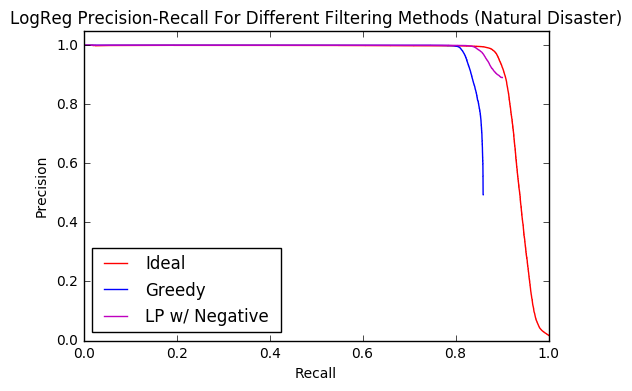

In [121]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')

plt.plot(ideal_prec_recall[1], ideal_prec_recall[0], color=colors[0], label="Ideal")
plt.plot(greedy_recall, greedy_prec, color=colors[1], label="Greedy")
plt.plot(neg_coverage_recall, neg_coverage_prec, color=colors[4], label="LP w/ Negative ")


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall For Different Filtering Methods (Natural Disaster)')
plt.show()

# 2) Soccer

In [10]:
output_directory = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/"
topic = "Soccer"

dp = DataPreprocessor(raw_data, topic)
labled_data = dp.get_labled_data(topic).select("tweet_id", "label")

In [11]:
positives = labled_data.where(col('label') == 1).select("tweet_id")
negatives = labled_data.where(col('label') == 0).select("tweet_id")

In [12]:
pos_dir = output_directory + topic + "/pos" 
positives.write.save(pos_dir, format="parquet")

In [15]:
neg_dir = output_directory + topic + "/neg"
negatives.write.save(neg_dir, format="parquet")

In [16]:
dp = DataPreprocessor(raw_data, topic, load_labled=True, filter_empty_hashtags=True)

In [17]:
train, valid, test = dp.temporal_split(topic, remove_topic_hashtags=True)

In [20]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Soccer"

train_pd = train.toPandas()
train_pd.to_csv(temporal_split_directory + topic + "/training.csv", encoding='utf-8', index=False)

In [23]:
valid_pd = valid.toPandas()
valid_pd.to_csv(temporal_split_directory + topic + "/validation.csv", encoding='utf-8', index=False)

In [24]:
test_pd = test.sample(False, 0.3, 123).toPandas()
test_pd.to_csv(temporal_split_directory + topic + "/test.csv", encoding='utf-8', index=False)

(Load CSV)

In [78]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Soccer"

train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna()

In [79]:
test = test_pd.drop_duplicates(subset='term').reset_index()
valid = validation_pd.drop_duplicates(subset='term').reset_index()
train = train_pd.drop_duplicates(subset='term').reset_index()

tf = TestFramework(train, valid, test)

Initializing Classifier....
Complete!


In [80]:
test_pos = test[test.label == 1]
test_neg = test[test.label == 0].sample(frac=0.5, random_state=123)

downsampled_test = pd.concat([test_pos, test_neg]).reset_index()

In [81]:
domain_stopwords = ['rt', 'amp', 'empty_location', 'empty_mention']
positive_set, negative_set = get_transformed_data(downsampled_test, tf.get_pipeline(),\
                                                  stopwords=domain_stopwords)

num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
    get_coverage(tf.get_pipeline(), positive_set, negative_set)

#pos/#neg = 0.152451351251


In [83]:
greedy_selected_features = greedy_max_cover(positive_set, negative_set, tf.get_pipeline(), k=50, print_solve_time=True)

Running Time: 147.351624012 Seconds


In [84]:
get_feature_by_index(tf.get_pipeline(), greedy_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,worldcup,Hashtag,28286,0
1,lfc,Hashtag,26876,0
2,worldcup2014,Hashtag,19050,0
3,arsenal,Hashtag,8592,0
4,cup,Term,8678,766
5,football,Hashtag,6868,0
6,halamadrid,Hashtag,6130,0
7,sports,Hashtag,5985,0
8,liverpool,Term,5923,237
9,usmnt,Hashtag,5281,0


In [85]:
filtered_greedy = tf.get_filtered_data_by_index(greedy_selected_features)

In [86]:
positive_set_subset, negative_set_subset = subset_transformed_data(positive_set, 3000, negative_set=negative_set)

num_positive_subset, feature_positive_coverage_subset, num_negative_subset, feature_negative_coverage_subset = \
    get_coverage(tf.get_pipeline(), positive_set_subset, negative_set_subset)

In [87]:
lp_selected_features = max_cover_with_negs_unweighted(feature_positive_coverage_subset,\
                                   feature_negative_coverage_subset,\
                                   num_positive_subset, num_negative_subset,\
                                   k=50, time_limit_secs=600, print_elapsed=True)

Running Time: 561.813875914 Seconds


In [88]:
get_feature_by_index(tf.get_pipeline(), lp_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,germany,Term,3262,208
1,adidas,Hashtag,1217,0
2,arsenal,Hashtag,8592,0
3,ballislife,Hashtag,605,0
4,ballondor,Hashtag,683,0
5,barca,Hashtag,596,0
6,barcelona,Hashtag,1789,0
7,brasil2014,Hashtag,910,0
8,brazil2014,Hashtag,3260,0
9,bvb,Hashtag,1096,0


In [89]:
filtered_lp = tf.get_filtered_data_by_index(lp_selected_features)

### 2-1) Solution Analysis

Features in both solutions:

In [90]:
common_features = [f for f in greedy_selected_features if f in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), common_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,worldcup,Hashtag,28286,0
1,lfc,Hashtag,26876,0
2,worldcup2014,Hashtag,19050,0
3,arsenal,Hashtag,8592,0
4,football,Hashtag,6868,0
5,halamadrid,Hashtag,6130,0
6,sports,Hashtag,5985,0
7,usmnt,Hashtag,5281,0
8,mcfc,Hashtag,4140,0
9,nufc,Hashtag,4051,0


Features only in greedy solution:

In [91]:
g_features = [f for f in greedy_selected_features if f not in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), g_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,cup,Term,8678,766
1,liverpool,Term,5923,237
2,goal,Term,6077,974
3,vs,Term,6056,1379
4,world,Term,8690,4444
5,game,Term,8294,4208
6,lfc,Mention,4099,40
7,match,Term,4755,741
8,brazil,Term,4069,341
9,league,Term,4097,503


Features only in LP solution:

In [92]:
l_features = [f for f in lp_selected_features if f not in greedy_selected_features]
get_feature_by_index(tf.get_pipeline(), l_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,adidas,Hashtag,1217,0
1,ballislife,Hashtag,605,0
2,ballondor,Hashtag,683,0
3,barca,Hashtag,596,0
4,barcelona,Hashtag,1789,0
5,brasil2014,Hashtag,910,0
6,bvb,Hashtag,1096,0
7,cardiff,Hashtag,1102,0
8,cr7,Hashtag,978,0
9,everton,Hashtag,753,0


## 2-2) Classifier Performance Analysis

In [93]:
_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()
    
_, _, greedy_avep, greedy_prec_recall = tf.run_with_filtered_test_data(filtered_greedy) 

_, _, lp_avep, lp_prec_recall = tf.run_with_filtered_test_data(filtered_lp)

In [94]:
results_pd = pd.DataFrame()

# Ideal
pos = len(test[test.label == 1])
tot = len(test)
print("Number of Topical Tweets w/o duplicates= {0}".format(pos))
print("Number of Tweets w/o duplicates = {0}".format(tot))

results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

# LP W/ Negative Coverage
pos_ret = len(filtered_lp[filtered_lp.label == 1])
tot_ret = len(filtered_lp)
recall = (float)(pos_ret) / pos

neg_coverage_prec = lp_prec_recall[0]
neg_coverage_recall = recall * lp_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Gurobi Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, lp_avep]])

# Greedy
pos_ret = len(filtered_greedy[filtered_greedy.label == 1])
tot_ret = len(filtered_greedy)
recall = (float)(pos_ret) / pos

greedy_prec = greedy_prec_recall[0]
greedy_recall = recall * greedy_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Greedy Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, greedy_avep]])

results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]
results_pd

Number of Topical Tweets w/o duplicates= 184380
Number of Tweets w/o duplicates = 2603249


,Model,Topical Retrieved,Total Retrieved,Recall,Precision,AveP
0,Ideal,184380,2603249,1.000000,0.070827,0.972215
0,LP with Negative Coverage (Gurobi Solver),166922,168432,0.905315,0.991035,0.999965
0,LP with Negative Coverage (Greedy Solver),156709,299688,0.849924,0.522907,0.995013


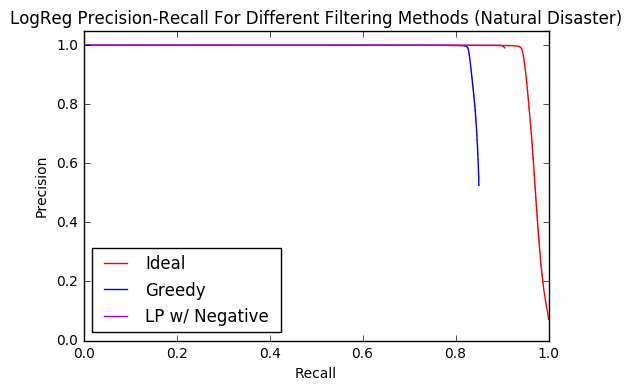

In [95]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')

plt.plot(ideal_prec_recall[1], ideal_prec_recall[0], color=colors[0], label="Ideal")
plt.plot(greedy_recall, greedy_prec, color=colors[1], label="Greedy")
plt.plot(neg_coverage_recall, neg_coverage_prec, color=colors[4], label="LP w/ Negative ")


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall For Different Filtering Methods (Natural Disaster)')
plt.show()

# 3) Human Disaster

In [96]:
output_directory = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/"
topic = "Human_Disaster"

dp = DataPreprocessor(raw_data, topic)
labled_data = dp.get_labled_data(topic).select("tweet_id", "label")

In [97]:
positives = labled_data.where(col('label') == 1).select("tweet_id")
negatives = labled_data.where(col('label') == 0).select("tweet_id")

In [100]:
pos_dir = output_directory + topic + "/pos" 
positives.write.save(pos_dir, format="parquet")

In [101]:
neg_dir = output_directory + topic + "/neg"
negatives.write.save(neg_dir, format="parquet")

In [102]:
dp = DataPreprocessor(raw_data, topic, load_labled=True, filter_empty_hashtags=True)

In [103]:
train, valid, test = dp.temporal_split(topic, remove_topic_hashtags=True)

In [106]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'

train_pd = train.toPandas()
train_pd.to_csv(temporal_split_directory + topic + "/training.csv", encoding='utf-8', index=False)

In [107]:
valid_pd = valid.toPandas()
valid_pd.to_csv(temporal_split_directory + topic + "/validation.csv", encoding='utf-8', index=False)

In [108]:
test_pd = test.sample(False, 0.3, 123).toPandas()
test_pd.to_csv(temporal_split_directory + topic + "/test.csv", encoding='utf-8', index=False)

(Load CSV)

In [8]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Human_Disaster"

train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna()

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
test = test_pd.drop_duplicates(subset='term').reset_index()
valid = validation_pd.drop_duplicates(subset='term').reset_index()
train = train_pd.drop_duplicates(subset='term').reset_index()

tf = TestFramework(train, valid, test)

Initializing Classifier....
Complete!


In [10]:
test_pos = test[test.label == 1]
test_neg = test[test.label == 0].sample(frac=0.5, random_state=123)

downsampled_test = pd.concat([test_pos, test_neg]).reset_index()

In [11]:
domain_stopwords = ['rt', 'amp', 'empty_location', 'empty_mention', 'http']
positive_set, negative_set = get_transformed_data(downsampled_test, tf.get_pipeline(),\
                                                  stopwords=domain_stopwords)

num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
    get_coverage(tf.get_pipeline(), positive_set, negative_set)

/usr/lib64/python2.7/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


#pos/#neg = 0.163735809632


In [12]:
greedy_selected_features = greedy_max_cover(positive_set, negative_set, tf.get_pipeline(), k=50, print_solve_time=True)

Running Time: 120.946544886 Seconds


In [13]:
get_feature_by_index(tf.get_pipeline(), greedy_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,gaza,Hashtag,30251,0
1,gazaunderattack,Hashtag,15837,0
2,isis,Hashtag,15619,0
3,israel,Hashtag,13038,0
4,syria,Hashtag,12471,0
5,israel,Term,6941,134
6,palestine,Hashtag,6586,0
7,freepalestine,Hashtag,6181,0
8,israeli,Term,5997,67
9,gaza,Term,5726,81


In [14]:
filtered_greedy = tf.get_filtered_data_by_index(greedy_selected_features)

In [15]:
positive_set_subset, negative_set_subset = subset_transformed_data(positive_set, 3000, negative_set=negative_set)

num_positive_subset, feature_positive_coverage_subset, num_negative_subset, feature_negative_coverage_subset = \
    get_coverage(tf.get_pipeline(), positive_set_subset, negative_set_subset)

In [16]:
lp_selected_features = max_cover_with_negs_unweighted(feature_positive_coverage_subset,\
                                   feature_negative_coverage_subset,\
                                   num_positive_subset, num_negative_subset,\
                                   k=50, time_limit_secs=600, print_elapsed=True)

Running Time: 701.577923059 Seconds


In [17]:
get_feature_by_index(tf.get_pipeline(), lp_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,abuja,Term,185,6
1,aircraft,Term,186,32
2,bodies,Term,665,63
3,boko,Term,572,24
4,children,Term,4582,400
5,crash,Term,1129,157
6,flight,Term,925,186
7,gaza,Term,5726,81
8,kiev,Term,90,29
9,malaysia,Term,740,63


In [18]:
filtered_lp = tf.get_filtered_data_by_index(lp_selected_features)

### 3-1) Solution Analysis

Features in both solutions:

In [19]:
common_features = [f for f in greedy_selected_features if f in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), common_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,gaza,Hashtag,30251,0
1,gazaunderattack,Hashtag,15837,0
2,isis,Hashtag,15619,0
3,israel,Hashtag,13038,0
4,syria,Hashtag,12471,0
5,palestine,Hashtag,6586,0
6,freepalestine,Hashtag,6181,0
7,gaza,Term,5726,81
8,prayforgaza,Hashtag,4717,0
9,children,Term,4582,400


Features only in greedy solution:

In [20]:
g_features = [f for f in greedy_selected_features if f not in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), g_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,israel,Term,6941,134
1,israeli,Term,5997,67
2,killed,Term,5215,430
3,iraq,Hashtag,4146,150
4,underattack,Term,3770,0
5,war,Term,3376,382
6,palestinian,Term,2797,36
7,palestinians,Term,2271,22
8,palestine,Term,1822,32
9,ifalasteen,Mention,1506,6


Features only in LP solution:

In [21]:
l_features = [f for f in lp_selected_features if f not in greedy_selected_features]
get_feature_by_index(tf.get_pipeline(), l_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,abuja,Term,185,6
1,aircraft,Term,186,32
2,bodies,Term,665,63
3,boko,Term,572,24
4,crash,Term,1129,157
5,flight,Term,925,186
6,kiev,Term,90,29
7,malaysia,Term,740,63
8,malaysian,Term,530,29
9,malaysians,Term,74,3


## 3-2) Classifier Performance Analysis

In [22]:
_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()
    
_, _, greedy_avep, greedy_prec_recall = tf.run_with_filtered_test_data(filtered_greedy) 

_, _, lp_avep, lp_prec_recall = tf.run_with_filtered_test_data(filtered_lp)

In [23]:
results_pd = pd.DataFrame()

# Ideal
pos = len(test[test.label == 1])
tot = len(test)
print("Number of Topical Tweets w/o duplicates= {0}".format(pos))
print("Number of Tweets w/o duplicates = {0}".format(tot))

results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

# LP W/ Negative Coverage
pos_ret = len(filtered_lp[filtered_lp.label == 1])
tot_ret = len(filtered_lp)
recall = (float)(pos_ret) / pos

neg_coverage_prec = lp_prec_recall[0]
neg_coverage_recall = recall * lp_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Gurobi Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, lp_avep]])

# Greedy
pos_ret = len(filtered_greedy[filtered_greedy.label == 1])
tot_ret = len(filtered_greedy)
recall = (float)(pos_ret) / pos

greedy_prec = greedy_prec_recall[0]
greedy_recall = recall * greedy_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Greedy Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, greedy_avep]])

results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]
results_pd

Number of Topical Tweets w/o duplicates= 119265
Number of Tweets w/o duplicates = 1576063


,Model,Topical Retrieved,Total Retrieved,Recall,Precision,AveP
0,Ideal,119265,1576063,1.000000,0.075673,0.927884
0,LP with Negative Coverage (Gurobi Solver),107080,119551,0.897833,0.895685,0.996609
0,LP with Negative Coverage (Greedy Solver),99826,132783,0.837010,0.751798,0.996067


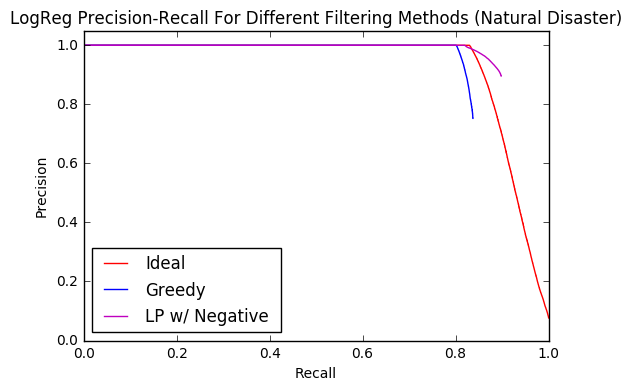

In [24]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')

plt.plot(ideal_prec_recall[1], ideal_prec_recall[0], color=colors[0], label="Ideal")
plt.plot(greedy_recall, greedy_prec, color=colors[1], label="Greedy")
plt.plot(neg_coverage_recall, neg_coverage_prec, color=colors[4], label="LP w/ Negative ")


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall For Different Filtering Methods (Natural Disaster)')
plt.show()

Analysis shows two invalid hashtags: #younusalgohar and #iss. Should label again and test performance again.

# 4) Tennis

In [25]:
output_directory = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/"
topic = "Tennis"

dp = DataPreprocessor(raw_data, topic)
labled_data = dp.get_labled_data(topic).select("tweet_id", "label")

In [26]:
positives = labled_data.where(col('label') == 1).select("tweet_id")
negatives = labled_data.where(col('label') == 0).select("tweet_id")

In [27]:
pos_dir = output_directory + topic + "/pos" 
positives.write.save(pos_dir, format="parquet")

In [28]:
neg_dir = output_directory + topic + "/neg"
negatives.write.save(neg_dir, format="parquet")

In [29]:
dp = DataPreprocessor(raw_data, topic, load_labled=True, filter_empty_hashtags=True)

In [30]:
train, valid, test = dp.temporal_split(topic, remove_topic_hashtags=True)

In [31]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'

train_pd = train.toPandas()
train_pd.to_csv(temporal_split_directory + topic + "/training.csv", encoding='utf-8', index=False)

In [33]:
valid_pd = valid.toPandas()
valid_pd.to_csv(temporal_split_directory + topic + "/validation.csv", encoding='utf-8', index=False)

In [34]:
test_pd = test.sample(False, 0.3, 123).toPandas()
test_pd.to_csv(temporal_split_directory + topic + "/test.csv", encoding='utf-8', index=False)

(Load CSV)

In [56]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Tennis"

train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna()

In [58]:
test = test_pd.drop_duplicates(subset='term').reset_index()
valid = validation_pd.drop_duplicates(subset='term').reset_index()
train = train_pd.drop_duplicates(subset='term').reset_index()

tf = TestFramework(train, valid, test)

Initializing Classifier....
Complete!


In [59]:
test_pos = test[test.label == 1]
test_neg = test[test.label == 0].sample(frac=0.5, random_state=123)

downsampled_test = pd.concat([test_pos, test_neg]).reset_index()

In [60]:
domain_stopwords = ['rt', 'amp', 'empty_location', 'empty_mention', 'http']
positive_set, negative_set = get_transformed_data(downsampled_test, tf.get_pipeline(),\
                                                  stopwords=domain_stopwords)

num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
    get_coverage(tf.get_pipeline(), positive_set, negative_set)

#pos/#neg = 0.0067536922418


In [61]:
greedy_selected_features = greedy_max_cover(positive_set, negative_set, tf.get_pipeline(), k=50, print_solve_time=True)

Running Time: 15.216219902 Seconds


In [62]:
get_feature_by_index(tf.get_pipeline(), greedy_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,wimbledon,Hashtag,1756,0
1,usopen,Hashtag,1147,0
2,tennis,Hashtag,878,0
3,tennis,Term,548,0
4,nadal,Hashtag,525,0
5,wimbledon,Mention,484,0
6,federer,Term,466,0
7,final,Term,426,32
8,match,Term,413,24
9,djokovic,Hashtag,387,0


In [63]:
filtered_greedy = tf.get_filtered_data_by_index(greedy_selected_features)

In [64]:
positive_set_subset, negative_set_subset = subset_transformed_data(positive_set, 3000, negative_set=negative_set)

num_positive_subset, feature_positive_coverage_subset, num_negative_subset, feature_negative_coverage_subset = \
    get_coverage(tf.get_pipeline(), positive_set_subset, negative_set_subset)

In [65]:
lp_selected_features = max_cover_with_negs_unweighted(feature_positive_coverage_subset,\
                                   feature_negative_coverage_subset,\
                                   num_positive_subset, num_negative_subset,\
                                   k=50, time_limit_secs=600, print_elapsed=True)

Running Time: 446.201888084 Seconds


In [66]:
get_feature_by_index(tf.get_pipeline(), lp_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,bouchard,Term,101,0
1,djokovic,Term,362,0
2,doubles,Term,62,1
3,fed,Term,36,3
4,federer,Term,466,0
5,match,Term,413,24
6,murray,Term,263,2
7,nadal,Term,252,0
8,novak,Term,216,0
9,roger,Term,263,3


In [67]:
filtered_lp = tf.get_filtered_data_by_index(lp_selected_features)

### 4-1) Solution Analysis

Features in both solutions:

In [68]:
common_features = [f for f in greedy_selected_features if f in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), common_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,wimbledon,Hashtag,1756,0
1,usopen,Hashtag,1147,0
2,tennis,Hashtag,878,0
3,tennis,Term,548,0
4,nadal,Hashtag,525,0
5,federer,Term,466,0
6,match,Term,413,24
7,djokovic,Hashtag,387,0
8,djokovic,Term,362,0
9,murray,Term,263,2


Features only in greedy solution:

In [69]:
g_features = [f for f in greedy_selected_features if f not in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), g_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,wimbledon,Mention,484,0
1,final,Term,426,32
2,set,Term,435,53
3,open,Term,283,48
4,win,Term,460,247
5,63,Term,186,6
6,court,Term,190,14
7,rafa,Term,175,0
8,64,Term,162,5
9,mens,Term,167,12


Features only in LP solution:

In [70]:
l_features = [f for f in lp_selected_features if f not in greedy_selected_features]
get_feature_by_index(tf.get_pipeline(), l_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,bouchard,Term,101,0
1,doubles,Term,62,1
2,fed,Term,36,3
3,sharapova,Term,79,0
4,afcwimbledon,Hashtag,25,0
5,atpworldtourfinals,Hashtag,55,0
6,cincytennis,Hashtag,28,0
7,daviscup,Hashtag,9,0
8,frenchopenfinal,Hashtag,64,0
9,murray,Hashtag,82,0


## 4-2) Classifier Performance Analysis

In [71]:
_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()
    
_, _, greedy_avep, greedy_prec_recall = tf.run_with_filtered_test_data(filtered_greedy) 

_, _, lp_avep, lp_prec_recall = tf.run_with_filtered_test_data(filtered_lp)

In [72]:
results_pd = pd.DataFrame()

# Ideal
pos = len(test[test.label == 1])
tot = len(test)
print("Number of Topical Tweets w/o duplicates= {0}".format(pos))
print("Number of Tweets w/o duplicates = {0}".format(tot))

results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

# LP W/ Negative Coverage
pos_ret = len(filtered_lp[filtered_lp.label == 1])
tot_ret = len(filtered_lp)
recall = (float)(pos_ret) / pos

neg_coverage_prec = lp_prec_recall[0]
neg_coverage_recall = recall * lp_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Gurobi Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, lp_avep]])

# Greedy
pos_ret = len(filtered_greedy[filtered_greedy.label == 1])
tot_ret = len(filtered_greedy)
recall = (float)(pos_ret) / pos

greedy_prec = greedy_prec_recall[0]
greedy_recall = recall * greedy_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Greedy Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, greedy_avep]])

results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]
results_pd

Number of Topical Tweets w/o duplicates= 6954
Number of Tweets w/o duplicates = 2066272


,Model,Topical Retrieved,Total Retrieved,Recall,Precision,AveP
0,Ideal,6954,2066272,1.000000,0.003365,0.851413
0,LP with Negative Coverage (Gurobi Solver),6210,14670,0.893011,0.423313,0.966176
0,LP with Negative Coverage (Greedy Solver),6152,106835,0.884671,0.057584,0.945827


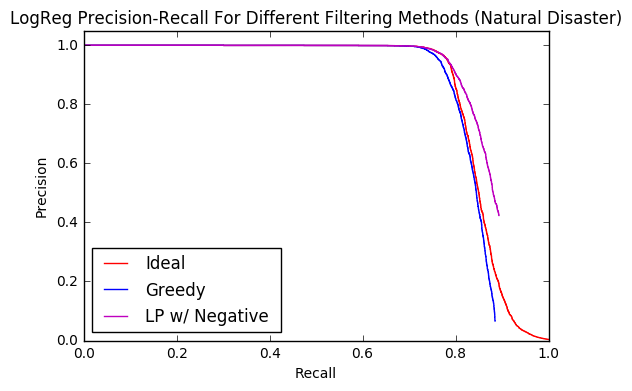

In [73]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')

plt.plot(ideal_prec_recall[1], ideal_prec_recall[0], color=colors[0], label="Ideal")
plt.plot(greedy_recall, greedy_prec, color=colors[1], label="Greedy")
plt.plot(neg_coverage_recall, neg_coverage_prec, color=colors[4], label="LP w/ Negative ")


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall For Different Filtering Methods (Natural Disaster)')
plt.show()

# 5) Health

In [74]:
output_directory = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/"
topic = "Health"

dp = DataPreprocessor(raw_data, topic)
labled_data = dp.get_labled_data(topic).select("tweet_id", "label")

In [75]:
positives = labled_data.where(col('label') == 1).select("tweet_id")
negatives = labled_data.where(col('label') == 0).select("tweet_id")

In [76]:
pos_dir = output_directory + topic + "/pos" 
positives.write.save(pos_dir, format="parquet")

In [77]:
neg_dir = output_directory + topic + "/neg"
negatives.write.save(neg_dir, format="parquet")

In [78]:
dp = DataPreprocessor(raw_data, topic, load_labled=True, filter_empty_hashtags=True)

In [79]:
train, valid, test = dp.temporal_split(topic, remove_topic_hashtags=True)

In [80]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'

train_pd = train.toPandas()
train_pd.to_csv(temporal_split_directory + topic + "/training.csv", encoding='utf-8', index=False)

In [81]:
valid_pd = valid.toPandas()
valid_pd.to_csv(temporal_split_directory + topic + "/validation.csv", encoding='utf-8', index=False)

In [82]:
test_pd = test.sample(False, 0.3, 123).toPandas()
test_pd.to_csv(temporal_split_directory + topic + "/test.csv", encoding='utf-8', index=False)

(Load CSV)

In [83]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Health"

train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna()

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [84]:
test = test_pd.drop_duplicates(subset='term').reset_index()
valid = validation_pd.drop_duplicates(subset='term').reset_index()
train = train_pd.drop_duplicates(subset='term').reset_index()

tf = TestFramework(train, valid, test)

Initializing Classifier....
Complete!


In [85]:
test_pos = test[test.label == 1]
test_neg = test[test.label == 0].sample(frac=0.5, random_state=123)

downsampled_test = pd.concat([test_pos, test_neg]).reset_index()

In [86]:
domain_stopwords = ['rt', 'amp', 'empty_location', 'empty_mention', 'http']
positive_set, negative_set = get_transformed_data(downsampled_test, tf.get_pipeline(),\
                                                  stopwords=domain_stopwords)

num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
    get_coverage(tf.get_pipeline(), positive_set, negative_set)

#pos/#neg = 0.0613360361794


In [87]:
greedy_selected_features = greedy_max_cover(positive_set, negative_set, tf.get_pipeline(), k=50, print_solve_time=True)

Running Time: 61.8270769119 Seconds


In [88]:
get_feature_by_index(tf.get_pipeline(), greedy_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,ebola,Hashtag,11366,0
1,uniteblue,Hashtag,4928,0
2,health,Hashtag,3222,0
3,health,Term,1819,97
4,healthcare,Hashtag,1650,0
5,ebola,Term,1681,52
6,job,Hashtag,1341,302
7,p2,Hashtag,953,27
8,tcot,Hashtag,1043,137
9,libcrib,Hashtag,746,1


In [89]:
filtered_greedy = tf.get_filtered_data_by_index(greedy_selected_features)

In [90]:
positive_set_subset, negative_set_subset = subset_transformed_data(positive_set, 3000, negative_set=negative_set)

num_positive_subset, feature_positive_coverage_subset, num_negative_subset, feature_negative_coverage_subset = \
    get_coverage(tf.get_pipeline(), positive_set_subset, negative_set_subset)

In [91]:
lp_selected_features = max_cover_with_negs_unweighted(feature_positive_coverage_subset,\
                                   feature_negative_coverage_subset,\
                                   num_positive_subset, num_negative_subset,\
                                   k=50, time_limit_secs=600, print_elapsed=True)

Running Time: 566.029417038 Seconds


In [92]:
get_feature_by_index(tf.get_pipeline(), lp_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,africa,Term,728,32
1,alfie,Term,8,2
2,downloaded,Term,4,6
3,ebola,Term,1681,52
4,geldof,Term,42,1
5,genocide,Term,9,7
6,stigma,Term,38,2
7,studios,Term,7,5
8,aids,Hashtag,326,0
9,alert,Hashtag,327,0


In [93]:
filtered_lp = tf.get_filtered_data_by_index(lp_selected_features)

### 5-1) Solution Analysis

Features in both solutions:

In [94]:
common_features = [f for f in greedy_selected_features if f in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), common_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,ebola,Hashtag,11366,0
1,uniteblue,Hashtag,4928,0
2,health,Hashtag,3222,0
3,healthcare,Hashtag,1650,0
4,ebola,Term,1681,52
5,hiv,Hashtag,723,0
6,africa,Term,728,32
7,ebolaoutbreak,Hashtag,471,0
8,cdc,Hashtag,370,0
9,sierraleone,Hashtag,337,0


Features only in greedy solution:

In [95]:
g_features = [f for f in greedy_selected_features if f not in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), g_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,health,Term,1819,97
1,job,Hashtag,1341,302
2,p2,Hashtag,953,27
3,tcot,Hashtag,1043,137
4,libcrib,Hashtag,746,1
5,outbreak,Term,723,4
6,patient,Term,721,23
7,tntweeters,Hashtag,652,23
8,virus,Term,631,5
9,jobs,Hashtag,722,192


Features only in LP solution:

In [96]:
l_features = [f for f in lp_selected_features if f not in greedy_selected_features]
get_feature_by_index(tf.get_pipeline(), l_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,alfie,Term,8,2
1,downloaded,Term,4,6
2,geldof,Term,42,1
3,genocide,Term,9,7
4,stigma,Term,38,2
5,studios,Term,7,5
6,allergy,Hashtag,18,0
7,antivirus,Hashtag,93,0
8,dengue,Hashtag,69,0
9,disease,Hashtag,76,0


## 5-2) Classifier Performance Analysis

In [97]:
_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()
    
_, _, greedy_avep, greedy_prec_recall = tf.run_with_filtered_test_data(filtered_greedy) 

_, _, lp_avep, lp_prec_recall = tf.run_with_filtered_test_data(filtered_lp)

In [98]:
results_pd = pd.DataFrame()

# Ideal
pos = len(test[test.label == 1])
tot = len(test)
print("Number of Topical Tweets w/o duplicates= {0}".format(pos))
print("Number of Tweets w/o duplicates = {0}".format(tot))

results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

# LP W/ Negative Coverage
pos_ret = len(filtered_lp[filtered_lp.label == 1])
tot_ret = len(filtered_lp)
recall = (float)(pos_ret) / pos

neg_coverage_prec = lp_prec_recall[0]
neg_coverage_recall = recall * lp_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Gurobi Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, lp_avep]])

# Greedy
pos_ret = len(filtered_greedy[filtered_greedy.label == 1])
tot_ret = len(filtered_greedy)
recall = (float)(pos_ret) / pos

greedy_prec = greedy_prec_recall[0]
greedy_recall = recall * greedy_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Greedy Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, greedy_avep]])

results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]
results_pd

Number of Topical Tweets w/o duplicates= 26203
Number of Tweets w/o duplicates = 880611


,Model,Topical Retrieved,Total Retrieved,Recall,Precision,AveP
0,Ideal,26203,880611,1.000000,0.029755,0.955948
0,LP with Negative Coverage (Gurobi Solver),25091,27459,0.957562,0.913762,0.998665
0,LP with Negative Coverage (Greedy Solver),24031,56311,0.917109,0.426755,0.993242


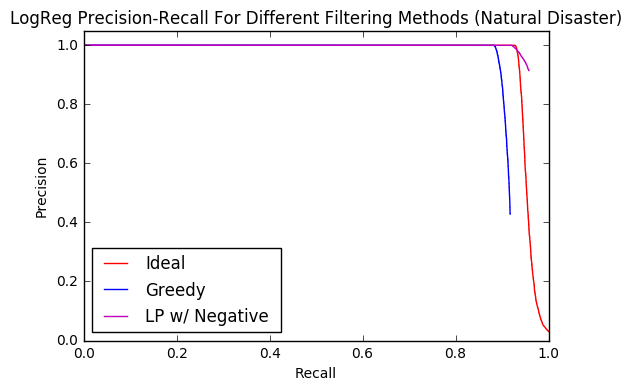

In [99]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')

plt.plot(ideal_prec_recall[1], ideal_prec_recall[0], color=colors[0], label="Ideal")
plt.plot(greedy_recall, greedy_prec, color=colors[1], label="Greedy")
plt.plot(neg_coverage_recall, neg_coverage_prec, color=colors[4], label="LP w/ Negative ")


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall For Different Filtering Methods (Natural Disaster)')
plt.show()

# 6) LGBT

In [100]:
output_directory = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/"
topic = "LGBT"

dp = DataPreprocessor(raw_data, topic)
labled_data = dp.get_labled_data(topic).select("tweet_id", "label")

In [101]:
positives = labled_data.where(col('label') == 1).select("tweet_id")
negatives = labled_data.where(col('label') == 0).select("tweet_id")

In [102]:
pos_dir = output_directory + topic + "/pos" 
positives.write.save(pos_dir, format="parquet")

In [103]:
neg_dir = output_directory + topic + "/neg"
negatives.write.save(neg_dir, format="parquet")

In [104]:
dp = DataPreprocessor(raw_data, topic, load_labled=True, filter_empty_hashtags=True)

In [105]:
train, valid, test = dp.temporal_split(topic, remove_topic_hashtags=True)

In [107]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'

train_pd = train.toPandas()
train_pd.to_csv(temporal_split_directory + topic + "/training.csv", encoding='utf-8', index=False)

In [108]:
valid_pd = valid.toPandas()
valid_pd.to_csv(temporal_split_directory + topic + "/validation.csv", encoding='utf-8', index=False)

In [109]:
test_pd = test.sample(False, 0.3, 123).toPandas()
test_pd.to_csv(temporal_split_directory + topic + "/test.csv", encoding='utf-8', index=False)

(Load CSV)

In [110]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "LGBT"

train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna()

In [111]:
test = test_pd.drop_duplicates(subset='term').reset_index()
valid = validation_pd.drop_duplicates(subset='term').reset_index()
train = train_pd.drop_duplicates(subset='term').reset_index()

tf = TestFramework(train, valid, test)

Initializing Classifier....
Complete!


In [112]:
test_pos = test[test.label == 1]
test_neg = test[test.label == 0].sample(frac=0.5, random_state=123)

downsampled_test = pd.concat([test_pos, test_neg]).reset_index()

In [113]:
domain_stopwords = ['rt', 'amp', 'empty_location', 'empty_mention', 'http']
positive_set, negative_set = get_transformed_data(downsampled_test, tf.get_pipeline(),\
                                                  stopwords=domain_stopwords)

num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
    get_coverage(tf.get_pipeline(), positive_set, negative_set)

#pos/#neg = 0.0262344147267


In [114]:
greedy_selected_features = greedy_max_cover(positive_set, negative_set, tf.get_pipeline(), k=50, print_solve_time=True)

Running Time: 22.1962511539 Seconds


In [115]:
get_feature_by_index(tf.get_pipeline(), greedy_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,uniteblue,Hashtag,9952,0
1,pjnet,Hashtag,9858,0
2,tcot,Hashtag,9623,0
3,2a,Hashtag,4522,0
4,teaparty,Hashtag,4150,0
5,ccot,Hashtag,3423,0
6,obama,Term,2278,125
7,tgdn,Hashtag,1863,0
8,stoprush,Hashtag,1725,0
9,p2,Hashtag,1614,0


In [116]:
filtered_greedy = tf.get_filtered_data_by_index(greedy_selected_features)

In [117]:
positive_set_subset, negative_set_subset = subset_transformed_data(positive_set, 3000, negative_set=negative_set)

num_positive_subset, feature_positive_coverage_subset, num_negative_subset, feature_negative_coverage_subset = \
    get_coverage(tf.get_pipeline(), positive_set_subset, negative_set_subset)

In [118]:
lp_selected_features = max_cover_with_negs_unweighted(feature_positive_coverage_subset,\
                                   feature_negative_coverage_subset,\
                                   num_positive_subset, num_negative_subset,\
                                   k=50, time_limit_secs=600, print_elapsed=True)

Running Time: 293.818546057 Seconds


In [119]:
get_feature_by_index(tf.get_pipeline(), lp_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,400,Term,17,28
1,budget,Term,99,24
2,catholic,Term,52,10
3,catholics,Term,20,1
4,christian,Term,151,52
5,conservative,Term,311,8
6,equality,Term,154,17
7,fund,Term,100,34
8,groups,Term,101,27
9,mass,Term,134,34


In [120]:
filtered_lp = tf.get_filtered_data_by_index(lp_selected_features)

### 6-1) Solution Analysis

Features in both solutions:

In [121]:
common_features = [f for f in greedy_selected_features if f in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), common_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,uniteblue,Hashtag,9952,0
1,pjnet,Hashtag,9858,0
2,tcot,Hashtag,9623,0
3,2a,Hashtag,4522,0
4,teaparty,Hashtag,4150,0
5,ccot,Hashtag,3423,0
6,tgdn,Hashtag,1863,0
7,stoprush,Hashtag,1725,0
8,p2,Hashtag,1614,0
9,pride,Hashtag,1215,0


Features only in greedy solution:

In [122]:
g_features = [f for f in greedy_selected_features if f not in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), g_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,obama,Term,2278,125
1,gop,Hashtag,1304,26
2,nra,Hashtag,1248,4
3,gun,Term,1242,45
4,loc_usa,Location,1743,647
5,lnyhbt,Hashtag,990,0
6,gop,Term,945,17
7,mt,Term,1006,98
8,america,Term,951,119
9,member,Term,893,71


Features only in LP solution:

In [123]:
l_features = [f for f in lp_selected_features if f not in greedy_selected_features]
get_feature_by_index(tf.get_pipeline(), l_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,400,Term,17,28
1,budget,Term,99,24
2,catholic,Term,52,10
3,catholics,Term,20,1
4,christian,Term,151,52
5,conservative,Term,311,8
6,equality,Term,154,17
7,fund,Term,100,34
8,groups,Term,101,27
9,mass,Term,134,34


## 6-2) Classifier Performance Analysis

In [124]:
_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()
    
_, _, greedy_avep, greedy_prec_recall = tf.run_with_filtered_test_data(filtered_greedy) 

_, _, lp_avep, lp_prec_recall = tf.run_with_filtered_test_data(filtered_lp)

In [125]:
results_pd = pd.DataFrame()

# Ideal
pos = len(test[test.label == 1])
tot = len(test)
print("Number of Topical Tweets w/o duplicates= {0}".format(pos))
print("Number of Tweets w/o duplicates = {0}".format(tot))

results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

# LP W/ Negative Coverage
pos_ret = len(filtered_lp[filtered_lp.label == 1])
tot_ret = len(filtered_lp)
recall = (float)(pos_ret) / pos

neg_coverage_prec = lp_prec_recall[0]
neg_coverage_recall = recall * lp_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Gurobi Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, lp_avep]])

# Greedy
pos_ret = len(filtered_greedy[filtered_greedy.label == 1])
tot_ret = len(filtered_greedy)
recall = (float)(pos_ret) / pos

greedy_prec = greedy_prec_recall[0]
greedy_recall = recall * greedy_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Greedy Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, greedy_avep]])

results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]
results_pd

Number of Topical Tweets w/o duplicates= 44668
Number of Tweets w/o duplicates = 3449966


,Model,Topical Retrieved,Total Retrieved,Recall,Precision,AveP
0,Ideal,44668,3449966,1.000000,0.012947,0.927860
0,LP with Negative Coverage (Gurobi Solver),42269,57970,0.946293,0.729153,0.999036
0,LP with Negative Coverage (Greedy Solver),40981,151524,0.917458,0.270459,0.995582


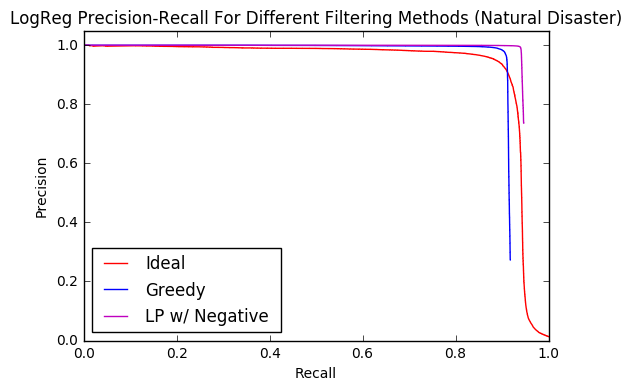

In [126]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')

plt.plot(ideal_prec_recall[1], ideal_prec_recall[0], color=colors[0], label="Ideal")
plt.plot(greedy_recall, greedy_prec, color=colors[1], label="Greedy")
plt.plot(neg_coverage_recall, neg_coverage_prec, color=colors[4], label="LP w/ Negative ")


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall For Different Filtering Methods (Natural Disaster)')
plt.show()